<a href="https://colab.research.google.com/github/Igli333/data-science/blob/main/Mini_Project_1_Igli_Balla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini Project 1
####Igli Balla
---




#####First we install all the required libraries for this project

In [ ]:
!pip install pandas
!pip install requests
!pip install ipython
!pip install beautifulsoup4
!pip install matplotlib

##### Then we import them

In [ ]:
import json
import os
import pandas as pd
import requests
import matplotlib.pyplot as plt

from IPython.display import HTML
from bs4 import BeautifulSoup as bs
from collections import Counter

##### Now, first we declare some functions that will prove helpful during the scraping process.

In [ ]:
# String manipulation needed to extract calories
def get_calories(string):
    span = '</span> '
    result = string[string.find(span) + len(span):string.rfind('</span>')]
    if len(result) == 0:
        return 0
    else:
        return float(result)


# A nullity check for rare cases
def get_image(figure):
    if figure is None:
        return ""
    else:
        return figure.get('img').get('src')


# Rarely recipes do not have points assigned to them
def personal_points(string):
    if string is None:
        return 0
    else:
        return int(string.text)

# Summery is comprised of recipe instructions made into a paragraph
def make_summary_paragraph(ul_list):
    if ul_list is None:
        return ''

    li_list = ul_list.find_all('li')
    return_string = ""
    for li in li_list:
        return_string += li.text + " "
    return return_string.strip()

# Two versions of HTML trees for recipe keys
def get_keys(results):
    if results is None:
        return []

    return_list = []

    for a in results.find_all('a'):
        if a.has_attr('title'):
            title = a['title']
        else:
            title = a.find('span')['title']

        return_list.append(title)

    return return_list

##### Before we start scraping we also have to make sure that the data has not yet been scraped before. All of the data will be saved in a CSV file after scraping.

In [ ]:
can_read_csv = True

if os.path.exists('recipes.csv') and os.path.getsize('recipes.csv') > 0:
    recipes = pd.read_csv('recipes.csv')
else:
    recipes = pd.DataFrame()
    can_read_csv = False

## Step 1 and 2
##### Scraping the data from SkinnyTaste and filtering:

*   Title
*   Figure
*   Calories
*   Personal Points
*   Summary
*   Recipe Keys




In [ ]:
if not can_read_csv:
    for page in range(1, 50):
        request = requests.get('https://www.skinnytaste.com/recipe-index/?_paged=' + str(page))
        soup = bs(request.text, 'html.parser')

        recipes_in_page = soup.find_all('article')
        for recipe in recipes_in_page:
            link = recipe.find('a').get('href')
            recipe_soup = bs(requests.get(link).text, 'html.parser')

            # Filtering out articles
            calories = get_calories(str(recipe_soup.find('span', class_='value-calories')))
            if calories == 0:
                continue

            recipe_dict = {
                'title': recipe_soup.find('h1', class_='entry-title').text,
                'figure': recipe.find('img').get('src'),
                'calories': calories,
                'personal_points': personal_points(recipe_soup.find('span', class_='recipe-ww-pp')),
                'summary': make_summary_paragraph(recipe_soup.find('ul', class_='wprm-recipe-instructions')),
                'recipe_key': get_keys(recipe_soup.find('ul', class_='cat-icons')),
            }

            recipes = pd.concat([recipes, pd.DataFrame([recipe_dict])], ignore_index=True)

    recipes.to_csv('recipes.csv')

## Step 3

##### Exploratory Data Analysis and Visualization

#### 1. Calories Distribution




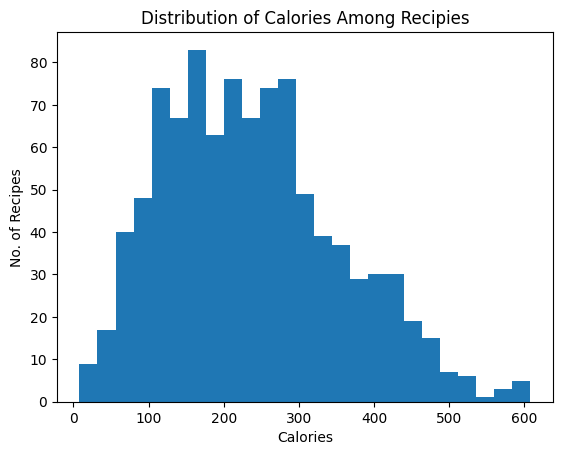

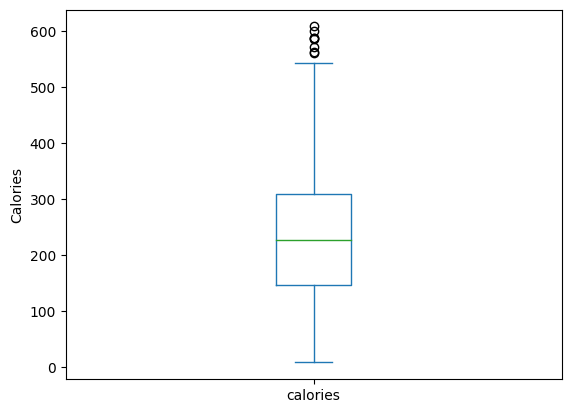

In [ ]:
recipes['calories'].plot(kind='hist', bins=25, title='Calories Distribution')
plt.title('Distribution of Calories Among Recipies')
plt.xlabel('Calories')
plt.ylabel('No. of Recipes')
plt.show()

recipes['calories'].plot(kind='box')
plt.ylabel('Calories')
plt.show()

#### 2. Recipe Key Distribution

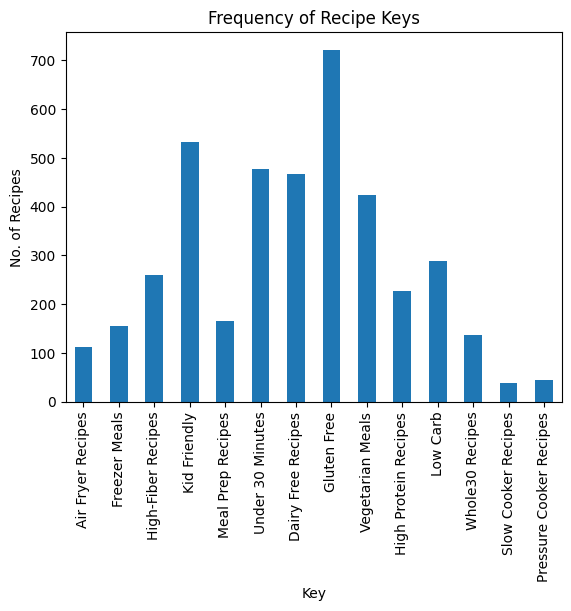

In [ ]:
all_keys = [key for sublist in recipes['recipe_key'] for key in sublist]
key_count = Counter(all_keys)

key_counts_df = pd.DataFrame(key_count.items(), columns=['Key', 'No. of Recipes'])
key_counts_df.plot(kind='bar', x='Key', y='No. of Recipes', legend=False)

plt.title('Frequency of Recipe Keys')
plt.xlabel('Key')
plt.ylabel('No. of Recipes')
plt.show()

#### 3. Points Distribution

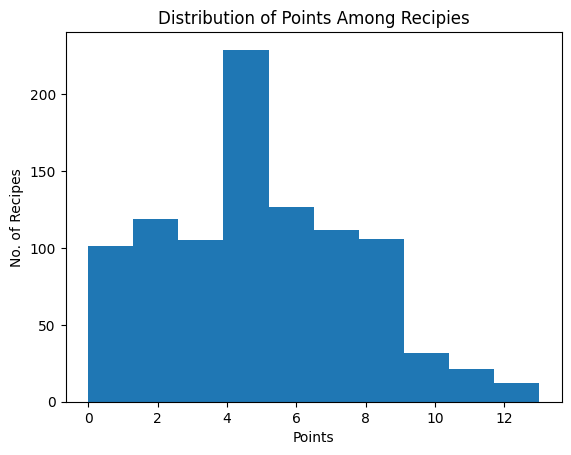

In [ ]:
recipes['personal_points'].plot(kind='hist', title='Rersonal Points Distribution')
plt.title('Distribution of Points Among Recipies')
plt.xlabel('Points')
plt.ylabel('No. of Recipes')
plt.show()

#### 4. Recipe Key over Average Points Distribution

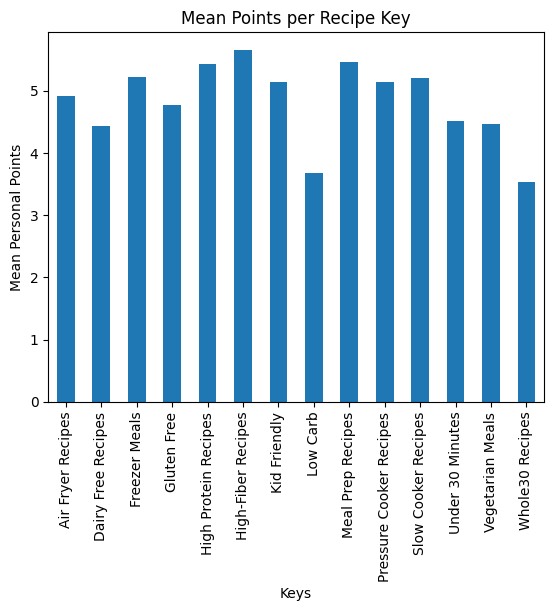

In [ ]:
expanded_df = recipes.explode('recipe_key')

average_scores = expanded_df.groupby('recipe_key')['personal_points'].mean()
average_scores.plot(kind='bar', x='recipe_key', y='personal_points', legend=False)

plt.title('Mean Points per Recipe Key')
plt.xlabel('Keys')
plt.ylabel('Mean Personal Points')
plt.show()

## Step 4
##### User Interaction

In [ ]:
print("What do you want to know?")
calories_start = int(input("Calories lower range: "))
calories_end = int(input("Calories upper range: "))
points_start = int(input("Personal points lower range: "))
points_end = int(input("Personal points upper range: "))

result = recipes[(recipes['calories'] >= calories_start)
                 & (recipes['calories'] <= calories_end)
                 & (recipes['personal_points'] >= points_start)
                 & (recipes['personal_points'] <= points_end)]
result = result.sort_values(['calories'], ascending=True)

HTML(result.head(10).to_html(escape=False, formatters={
      'figure': lambda path: '<img src="' + path + '" style=max-height:200px;"/>',
      'recipe_key': lambda keys: '<br>'.join(keys)
}))

What do you want to know?
Calories lower range: 200
Calories upper range: 240
Personal points lower range: 1
Personal points upper range: 4


,title,figure,calories,personal_points,summary,recipe_key
48,Filipino BBQ Pork Skewers,,201.0,2,"Mix all ingredients in a large non-reactive bowl and marinate the pork at least 6 hours or overnight. If using wooden skewers, soak in water at least an hour so they don’t burn on the grill. Discard unused marinade and thread the meat onto 8 skewers. Preheat the grill and spray the grates with oil. When ready, grill about 5 to 6 minutes on each side, until cooked through.",Dairy Free RecipesGluten FreeHigh Protein RecipesLow Carb
694,Shrimp Dumpling Lettuce Wraps or Rice Bowls,,201.0,2,"To make the quick-pickled carrots, combine ¼ cup rice vinegar with 2 Tbsp water and the honey or sugar. Add the carrots and stir to combine. Set aside.",Dairy Free RecipesGluten FreeKid FriendlyLow CarbUnder 30 Minutes
47,Grilled Shrimp,,202.0,3,"If using wooden skewers, soak them in water at least 20 minutes. Season the shrimp with salt and pepper. Heat the grill over medium heat until hot, then clean and oil the grates. Meanwhile melt butter in a small skillet over medium-low heat. Add garlic and cook on low heat until fragrant but not browned, about 1 to 2 minutes. Add the paprika and remove from heat. Thread the shrimp onto the skewers and place on the prepared grill and cook until shrimp turns pink on the bottom, about 2 to 3 minutes; turn and continue cooking until shrimp is opaque and cooked through, about 2 minutes. Transfer to a platter and Brush the butter over the shrimp skewers. Garnish with parsley and serve with lemon wedges.",Dairy Free RecipesGluten FreeHigh Protein RecipesKid FriendlyLow CarbUnder 30 Minutes
747,Sweet and Spicy Glazed Salmon,,202.0,2,"Preheat oven to 400F. Spray a sheet pan with olive oil and set aside. Place salmon on the sheet pan and season with 1/4 teaspoon salt. In a small bowl combine red chili sauce sauce, sriracha and ginger. Brush over the salmon. Roast in the oven 400F 8 to 10 minutes. Garnish with scallions.",Air Fryer RecipesDairy Free RecipesGluten FreeLow CarbUnder 30 Minutes
581,Waffled Vegetable Latkes,,205.0,4,"Using a box grater, grate all the veggies, saving the potatoes for last to prevent browning. Squeeze out all the excess liquid well with a cheese cloth or towels. Stir in matzo meal or flour, baking powder, salt and pepper. Add the eggs and mix well. Spray waffle iron and heat on medium-low heat. Place scant 2/3 cup in the center of the waffle iron and close, cook 5 minutes, until browned and crisp on the edges and cooked through in the center. Set aside and repeat with the remaining mixture.",Dairy Free RecipesGluten FreeHigh-Fiber RecipesKid FriendlyUnder 30 MinutesVegetarian Meals
582,Waffled Vegetable Latkes,,205.0,4,"Using a box grater, grate all the veggies, saving the potatoes for last to prevent browning. Squeeze out all the excess liquid well with a cheese cloth or towels. Stir in matzo meal or flour, baking powder, salt and pepper. Add the eggs and mix well. Spray waffle iron and heat on medium-low heat. Place scant 2/3 cup in the center of the waffle iron and close, cook 5 minutes, until browned and crisp on the edges and cooked through in the center. Set aside and repeat with the remaining mixture.",Dairy Free RecipesGluten FreeHigh-Fiber RecipesKid FriendlyUnder 30 MinutesVegetarian Meals
740,Honeynut Squash Recipe with Maple and Pecans,,205.0,4,"Preheat oven to 425F. Scoop the seeds out of the squash and discard. Arrange squash halves cut-side up on a baking sheet. Spread the butter evenly over the top and in each cavity. Sprinkle with pinch of salt and cinnamon. Roast until tender in the center of the oven, 35 to 38 minutes. Drizzle each half with 1 teaspoon maple syrup and 1/2 tbsp chopped pecan, serve hot.",Gluten FreeHigh-Fiber RecipesKid FriendlyVegetarian Meals
894,Crock Pot Picadillo,,207.0,4,"Brown meat in a large deep skillet on medium-high heat; season with generously with salt and a little pepper. Use a wooden spoon to break the meat up into small pieces. When meat is